# MSA 2024 Phase 2 - Part 1

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Find all variables and understand them

In [5]:
#Importing data
Sales_data = pd.read_csv("store_sales.csv", encoding='latin1',delimiter=',',header='infer')
Sales_data["Order Date"] = pd.to_datetime(Sales_data["Order Date"])
Sales_data["Ship Date"] = pd.to_datetime(Sales_data["Ship Date"])
print("Below is the first 10 rows in the dataset")
print(Sales_data.head(n=10))
print("Below is the basic information about the data contained in each column")
print(Sales_data.info())
print("Below is the basic summary of the data")
print(Sales_data.describe())

#sorting the dataset by order date for better visibility
Sales_data.sort_values(by='Order Date', inplace = True) 

Below is the first 10 rows in the dataset
   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
3       6  CA-2014-115812 2014-06-09 2014-06-14  Standard Class    BH-11710   
4      11  CA-2014-115812 2014-06-09 2014-06-14  Standard Class    BH-11710   
5      24  US-2017-156909 2017-07-16 2017-07-18    Second Class    SF-20065   
6      25  CA-2015-106320 2015-09-25 2015-09-30  Standard Class    EB-13870   
7      28  US-2015-150630 2015-09-17 2015-09-21  Standard Class    TB-21520   
8      30  US-2015-150630 2015-09-17 2015-09-21  Standard Class    TB-21520   
9      37  CA-2016-117590 2016-12-08 2016-12-10     First Class    GH-14485   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute

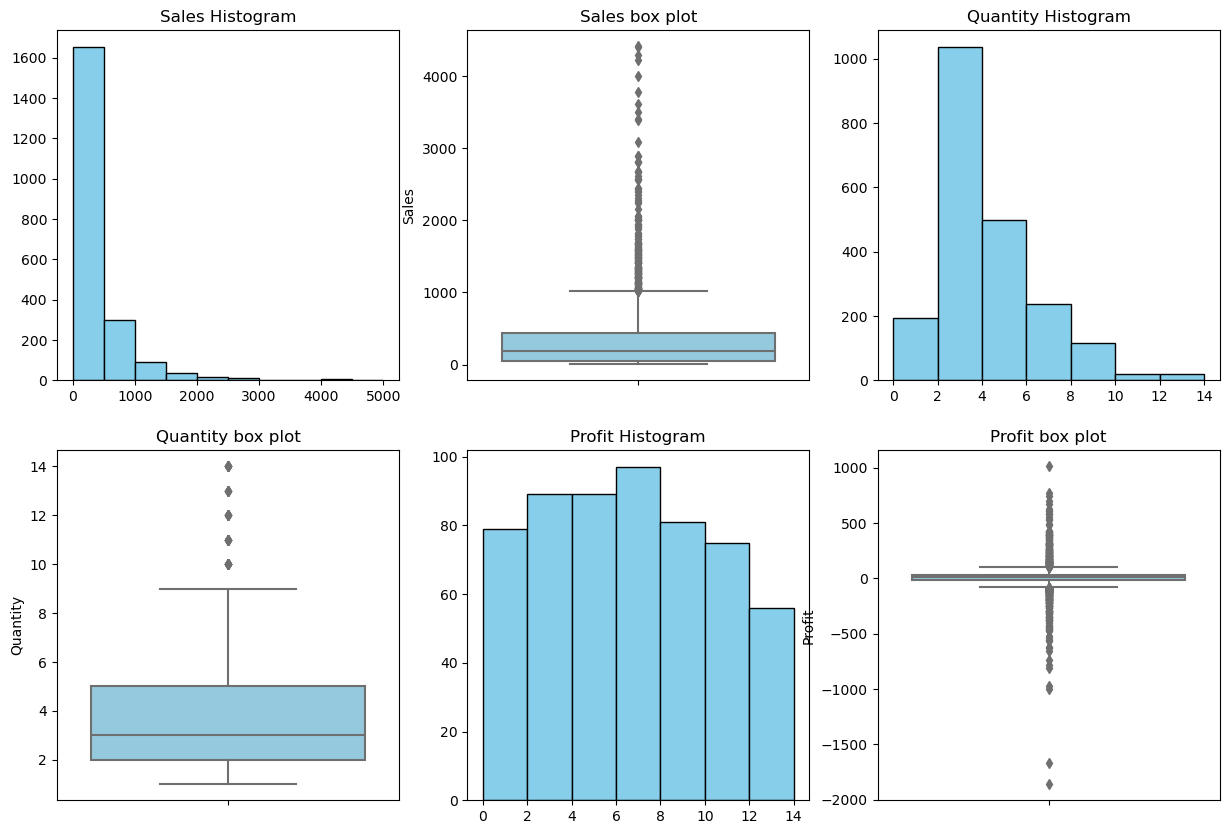

In [6]:
# Visualizing numeric columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10)) #creates the frame to fill the plots in

# Histogram of sales 
axes[0, 0].hist(Sales_data['Sales'], bins=(0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000), color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sales Histogram')

# Box plot of sales
sns.boxplot(y=Sales_data['Sales'], color='skyblue', ax=axes[0, 1])
plt.ylabel('Sales')
axes[0, 1].set_title('Sales box plot')

# Histogram of Quantity 
axes[0, 2].hist(Sales_data['Quantity'], bins=(0,2,4,6,8,10,12,14), color='skyblue', edgecolor='black')
axes[0, 2].set_title('Quantity Histogram')

# Box plot of Quantity
sns.boxplot(y=Sales_data['Quantity'], color='skyblue', ax=axes[1, 0])
plt.ylabel('Quantity')
axes[1,0].set_title('Quantity box plot')

# Histogram of Profit 
axes[1, 1].hist(Sales_data['Profit'], bins=(0,2,4,6,8,10,12,14), color='skyblue', edgecolor='black')
axes[1, 1].set_title('Profit Histogram')

# Box plot of Profit
sns.boxplot(y=Sales_data['Profit'], color='skyblue', ax=axes[1, 2])
axes[1,2].set_title('Profit box plot')

plt.show()


## 2. Clean 

In [7]:
missing_data = Sales_data.isnull().sum().to_frame()
missing_data


0
Row ID         0
Order ID       0
Order Date     0
Ship Date      0
Ship Mode      0
Customer ID    0
Customer Name  0
Segment        0
Country        0
City           0
State          0
Postal Code    0
Region         0
Product ID     0
Category       0
Sub-Category   0
Product Name   0
Sales          0
Quantity       0
Discount       0
Profit         0

Based on the above result we can see that there are no missing data. Therefore we have a complete data set. However we can see from the Histogram and Box plots that here are many outliers. An important response variable we aim to look at is Sales which seems to be heavily right skewed. Sales have a minimum value of 1.892 as seen in the summary output. This makes sense because usually we don't expect negative values for sales. 

In [6]:
Sales_data.columns


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [7]:
print("Unique Categories: ", len(Sales_data['Category'].unique()))
print("Unique Sub- Categories: ", len(Sales_data['Sub-Category'].unique()))
print("Unique Regions: ", len(Sales_data['Region'].unique()))
print("Unique Ship Mode: ",len(Sales_data['Ship Mode'].unique()))
print("Unique States: ", len(Sales_data['State'].unique()))
print("Unique Cities: ",len(Sales_data['City'].unique())) 
print("Unique Countries: ",len(Sales_data['Country'].unique()))
print("Unique Segments: ",len(Sales_data['Segment'].unique()))


Unique Categories:  1
Unique Sub- Categories:  4
Unique Regions:  4
Unique Ship Mode:  4
Unique States:  48
Unique Cities:  371
Unique Countries:  1
Unique Segments:  3


Category and Country have 1 unique value therefore they're dropped because they don't add information. City contains a large number of unique values which means that it's not suitable for one-hot encoding. Hence the variables to be one-hot encoded are Sub-Category, Regions, Ship Mode, State, Segment.

In [8]:
columns_to_keep = ['Sub-Category', 'Region', 'State', 'Ship Mode', 'Sales', 'Quantity', 'Discount', 'Profit', 'Segment', 'Order Date']
Reduced_Sales_data = Sales_data[columns_to_keep]

# Apply one-hot encoding to relevant columns
categorical_columns = ['Sub-Category', 'Region', 'State', 'Ship Mode', 'Segment']
Sales_data_encoded = pd.get_dummies(Reduced_Sales_data, columns=categorical_columns, drop_first=False) # can also drop_first = True however since the number of new vectors is relatively low we can keep them for visualisation
Sales_data_encoded.head()

Sales  Quantity  Discount    Profit Order Date  \
1577  2573.820         9       0.0  746.4078 2014-01-06   
1626    76.728         3       0.6  -53.7096 2014-01-07   
181     51.940         1       0.0   21.2954 2014-01-10   
150      9.940         2       0.0    3.0814 2014-01-11   
631    545.940         6       0.0   87.3504 2014-01-13   

      Sub-Category_Bookcases  Sub-Category_Chairs  Sub-Category_Furnishings  \
1577                   False                 True                     False   
1626                   False                False                      True   
181                    False                False                      True   
150                    False                False                      True   
631                    False                 True                     False   

      Sub-Category_Tables  Region_Central  ...  State_West Virginia  \
1577                False           False  ...                False   
1626                False            True  ...                False   
181                 False           False  ...                False   
150                 False           False  ...                False   
631                 False           False  ...                False   

      State_Wisconsin  State_Wyoming  Ship Mode_First Class  \
1577            False          False                  False   
1626            False          False                  False   
181             False          False                  False   
150             False          False                   True   
631             False          False                  False   

      Ship Mode_Same Day  Ship Mode_Second Class  Ship Mode_Standard Class  \
1577               False                   False                      True   
1626               False                   False                      True   
181                False                   False                      True   
150                False                   False                     False   
631                False                    True                     False   

      Segment_Consumer  Segment_Corporate  Segment_Home Office  
1577             False              False                 True  
1626              True              False                False  
181              False               True                False  
150               True              False                False  
631               True              False                False  

[5 rows x 68 columns]

In [9]:
# Sum or aggregate numeric features by Order Date
numeric_aggregation = Sales_data_encoded.groupby('Order Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Profit': 'sum'
}).reset_index()

# Sum one-hot encoded variables by Order Date
one_hot_aggregation = Sales_data_encoded.groupby('Order Date').sum().reset_index()
one_hot_aggregation.drop(columns=['Sales', 'Quantity','Discount','Profit'], inplace=True)
# Ensure the date columns are aligned correctly
aggregated_df = pd.merge(numeric_aggregation, one_hot_aggregation, on='Order Date', how='left')
aggregated_df


Order Date      Sales  Quantity  Discount    Profit  \
0   2014-01-06  2573.8200         9  0.000000  746.4078   
1   2014-01-07    76.7280         3  0.600000  -53.7096   
2   2014-01-10    51.9400         1  0.000000   21.2954   
3   2014-01-11     9.9400         2  0.000000    3.0814   
4   2014-01-13   879.9390         9  0.075000   91.2798   
..         ...        ...       ...       ...       ...   
884 2017-12-24  1393.4940        14  0.100000  222.9092   
885 2017-12-25   832.4540        14  0.160000   -7.0763   
886 2017-12-28   551.2568        17  0.336667  -49.6680   
887 2017-12-29  2330.7180        26  0.033333  492.6236   
888 2017-12-30   323.1360         4  0.200000   12.1176   

     Sub-Category_Bookcases  Sub-Category_Chairs  Sub-Category_Furnishings  \
0                         0                    1                         0   
1                         0                    0                         1   
2                         0                    0                         1   
3                         0                    0                         1   
4                         1                    1                         0   
..                      ...                  ...                       ...   
884                       0                    3                         2   
885                       1                    1                         2   
886                       1                    2                         3   
887                       0                    4                         2   
888                       1                    0                         0   

     Sub-Category_Tables  Region_Central  ...  State_West Virginia  \
0                      0               0  ...                    0   
1                      0               1  ...                    0   
2                      0               0  ...                    0   
3                      0               0  ...                    0   
4                      0               0  ...                    0   
..                   ...             ...  ...                  ...   
884                    0               0  ...                    0   
885                    1               0  ...                    0   
886                    0               4  ...                    0   
887                    0               0  ...                    0   
888                    0               0  ...                    0   

     State_Wisconsin  State_Wyoming  Ship Mode_First Class  \
0                  0              0                      0   
1                  0              0                      0   
2                  0              0                      0   
3                  0              0                      1   
4                  0              0                      0   
..               ...            ...                    ...   
884                0              0                      0   
885                0              0                      1   
886                0              0                      1   
887                0              0                      0   
888                0              0                      0   

     Ship Mode_Same Day  Ship Mode_Second Class  Ship Mode_Standard Class  \
0                     0                       0                         1   
1                     0                       0                         1   
2                     0                       0                         1   
3                     0                       0                         0   
4                     0                       1                         1   
..                  ...                     ...                       ...   
884                   0                       0                         5   
885                   0                       1                         3   
886                   0                       0                         5   
88

Looking at the first 5 rows we can see that some dates are skipped. Perhaps no orders were made on those dates. I have aggregated the data further to be monthly data.

In [10]:
aggregated_df.set_index('Order Date', inplace=True) # must set the order date as the index for it to be aggregated correctly

In [8]:
# Downsample to monthly frequency, summing the sales for each month

# Resample the data to monthly frequency, however Discount is a ratio so it should be the mean instead of sum

monthly_resampled_df = aggregated_df.resample('M').agg({
    
    'Discount': 'mean',
    
    # One-hot encoded columns should be summed
    **{col: 'sum' for col in aggregated_df.columns if col not in [ 'Discount']}
})

monthly_resampled_df

Discount       Sales  Quantity     Profit  Sub-Category_Bookcases  \
Order Date                                                                      
2014-01-31  0.201923   6242.5250        70   805.4665                       5   
2014-02-28  0.160000   1839.6580        23   120.6917                       0   
2014-03-31  0.203088  14573.9560       131 -1128.6550                       3   
2014-04-30  0.113095   7944.8370        81   554.3801                       1   
2014-05-31  0.269792   6912.7870        97  -349.8776                       2   
2014-06-30  0.170351  13206.1256       122   596.3153                       3   
2014-07-31  0.176481  10821.0510       114   374.2467                       2   
2014-08-31  0.147917   7320.3465       107   663.4717                       2   
2014-09-30  0.149097  23816.4808       208  1858.5976                       5   
2014-10-31  0.171354  12304.2470       130   249.1645                       1   
2014-11-30  0.168977  21564.8727       228  -297.8958                       9   
2014-12-31  0.226333  30645.9665       312  2011.8198                       4   
2015-01-31  0.247500  11739.9416        88 -3014.2000                       2   
2015-02-28  0.188889   3134.3740        45   394.8948                       1   
2015-03-31  0.162292  12499.7830       111  1455.0573                       5   
2015-04-30  0.127179  10475.6985       107   338.6502                       2   
2015-05-31  0.202167   9374.9505       126   900.5847                       2   
2015-06-30  0.153704   7714.1790       112  -412.6597                       1   
2015-07-31  0.175000  13674.4200       162  -325.0938                       7   
2015-08-31  0.212448   9638.5922       112  -487.4709                       6   
2015-09-30  0.120038  26273.0230       205  1350.1185                       9   
2015-10-31  0.190351  12026.6235       140  -605.5163                       6   
2015-11-30  0.126278  30880.8325       310  2992.0240                      12   
2015-12-31  0.207455  23085.8192       257   428.8141                       8   
2016-01-31  0.151111   7622.7430       101   303.9607                       4   
2016-02-29  0.174242   3925.5510        69   377.0352                       1   
2016-03-31  0.209365  12801.0920       162  -555.2680                       5   
2016-04-30  0.170614  13212.0900       146   364.8334                       4   
2016-05-31  0.147727  15119.8350       181  1824.4739                       0   
2016-06-30  0.198542  13070.5720       128  -106.2665                       5   
2016-07-31  0.172059  13068.5190       159  1038.9073                       4   
2016-08-31  0.235000  12483.2323       115  -494.1457                       3   
2016-09-30  0.170191  27262.8809       284   702.6025                      11   
2016-10-31  0.233246  11872.5770       187  -144.6600                       4   
2016-11-30  0.184960  31783.6288       318   819.8088                       8   
2016-12-31  0.136658  36678.7150       343  2828.6715                       5   
2017-01-31  0.081111   5964.0320        86   -39.4402                       2   
2017-02-28  0.205949   6866.3374        71  -199.0421                       5   
2017-03-31  0.144867  10893.4448       123  1000.8532                       4   
2017-04-30  0.180500   9065.9581       175   202.4624                       7   
2017-05-31  0.204400  16957.5582       184   -72.8829                       9   
2017-06-30  0.161812  19008.5867       176   904.9956                      10   
2017-07-31  0.173651  11813.0220       183   324.6244                       4   
2017-08-31  0.168651  15441.8740       127   322.2390                       3   
2017-09-30  0.157902  29028.2060       302  1548.6837                       7   
2017-10-31  0.170949  21884.0682       252 -2526.9203                       7   
2017-11-30  0.157443  37056.7150       364   406.0637                       6   
2017-12-31  0.153781  31407.4668       394 

In [11]:
monthly_resampled_df.shape


(48, 67)

In [52]:
monthly_resampled_df.describe()

Discount         Sales   Quantity       Profit  \
count  48.000000     48.000000   48.00000    48.000000   
mean    0.175342  15458.329069  167.25000   384.401517   
std     0.035837   9103.800668   88.59074  1080.728622   
min     0.081111   1839.658000   23.00000 -3014.200000   
25%     0.153762   9297.702400  110.00000  -158.255525   
50%     0.171152  12650.437500  135.50000   369.540050   
75%     0.201984  21644.671575  205.75000   901.687425   
max     0.269792  37056.715000  394.00000  2992.024000   

       Sub-Category_Bookcases  Sub-Category_Chairs  Sub-Category_Furnishings  \
count               48.000000            48.000000                  48.00000   
mean                 4.750000            12.854167                  19.93750   
std                  3.118237             7.797953                  11.07884   
min                  0.000000             2.000000                   3.00000   
25%                  2.000000             6.750000                  11.75000   
50%                  4.000000            11.500000                  17.00000   
75%                  7.000000            15.500000                  27.25000   
max                 12.000000            32.000000                  50.00000   

       Sub-Category_Tables  Region_Central  Region_East  ...  \
count            48.000000       48.000000    48.000000  ...   
mean              6.645833       10.020833    12.520833  ...   
std               4.319622        5.459676     7.863164  ...   
min               1.000000        2.000000     0.000000  ...   
25%               4.000000        5.750000     7.000000  ...   
50%               6.000000        9.000000    11.000000  ...   
75%               8.000000       14.000000    17.250000  ...   
max              22.000000       23.000000    33.000000  ...   

       State_West Virginia  State_Wisconsin  State_Wyoming  \
count            48.000000        48.000000      48.000000   
mean              0.020833         0.666667       0.020833   
std               0.144338         1.078481       0.144338   
min               0.000000         0.000000       0.000000   
25%               0.000000         0.000000       0.000000   
50%               0.000000         0.000000       0.000000   
75%               0.000000         1.000000       0.000000   
max               1.000000         4.000000       1.000000   

       Ship Mode_First Class  Ship Mode_Same Day  Ship Mode_Second Class  \
count              48.000000           48.000000               48.000000   
mean                6.812500            2.479167                8.895833   
std                 4.760906            2.633577                5.597262   
min                 0.000000            0.000000                1.000000   
25%                 3.750000            0.750000                4.000000   
50%                 6.000000            2.000000                8.500000   
75%                 9.000000            4.000000               11.250000   
max                23.000000           13.000000               23.000000   

       Ship Mode_Standard Class  Segment_Consumer  Segment_Corporate  \
count                 48.000000          48.00000          48.000000   
mean                  26.000000          23.18750          13.458333   
std                   14.416303          12.65694           7.743105   
min                    3.000000           5.00000           1.000000   
25%                   14.750000          13.75000           8.000000   
50%                   22.500000          20.00000          11.500000   
75%                   34.250000          30.25000          18.000000   
max                   66.000000          59.00000          31.000000   

       Segment_Home Office  
count            48.000000  
mean              7.541667  
std               5.115510  
min               0.000000  
25%               4.000000  
50%               6.000000  
75%              11.000000  
max              24.000000  

[8 rows x 67 columns]

After aggregating the data, checking the shape of the data shows that we now have monthly data for years 2014 to 2017 with no skipped month in between which makes it suitable for timeseries analysis. 

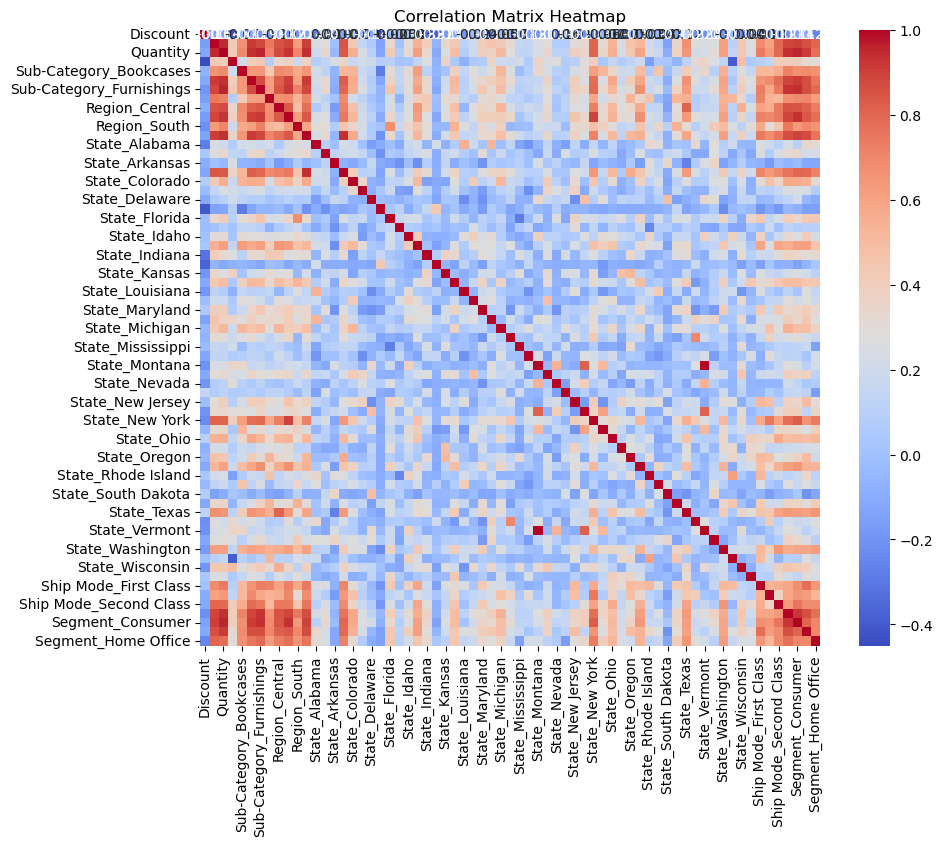

In [9]:
# correlation matrix
correlation_matrix = monthly_resampled_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

It seems that alot of the one hot encoded variables are highly correlated to each other. Some represent categories within the same overarching categorical feature (like different states within regions and different sub-categories within a category). High correlations (close to 1 or -1) indicate redundancy or overlap in the information they provide. This can lead to unstable estimates in regression models. Perhaps drop quantity as it seems to be highly correlated with sales. Therefore variables with high correlations will have one of the two dropped.

In [9]:
# Identifying outliers using IQR method
Q1 = monthly_resampled_df['Sales'].quantile(0.25)
Q3 = monthly_resampled_df['Sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = monthly_resampled_df[(monthly_resampled_df['Sales'] < (Q1 - 1.5 * IQR)) | (monthly_resampled_df['Sales'] > (Q3 + 1.5 * IQR))]

# Optionally, cap the outliers
monthly_resampled_df['Sales'] = np.where(monthly_resampled_df['Sales'] > (Q3 + 1.5 * IQR), Q3 + 1.5 * IQR, monthly_resampled_df['Sales'])
monthly_resampled_df['Sales'] = np.where(monthly_resampled_df['Sales'] < (Q1 - 1.5 * IQR), Q1 - 1.5 * IQR, monthly_resampled_df['Sales'])

We can see that with IQR method there were no outliers. However we will check the residuals after fitting model to see any unusual values.

In [10]:
#Feature selection to help reduce the correlation between the variables
corr_matrix = monthly_resampled_df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than a threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features
monthly_red_cols = monthly_resampled_df.drop(columns=to_drop)

Previously we had 67 columns and after feature selection we have 57 columns.

## 3. Visualise data

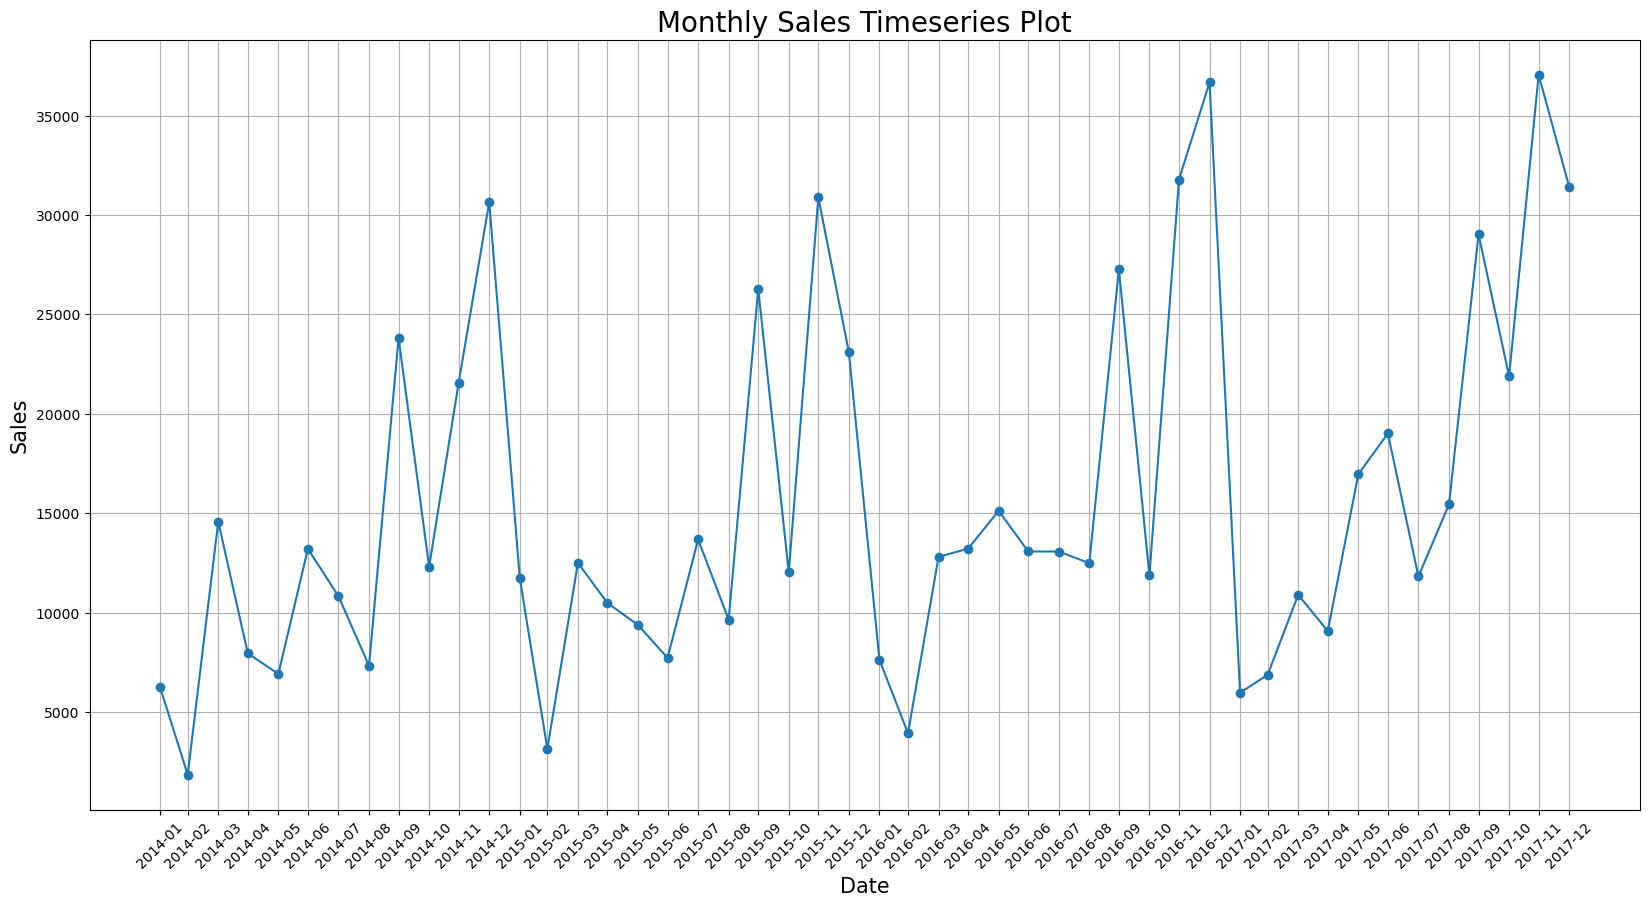

In [11]:
# Plotting the line graph of sales by date
#monthly_resampled_df = monthly_resampled_df.reset_index() #reset the index to gain access to the order date column
plt.figure(figsize=(20, 10))
plt.plot(monthly_red_cols.index, monthly_red_cols["Sales"], marker='o', linestyle='-')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title("Monthly Sales Timeseries Plot", fontsize=20)
plt.xticks(monthly_red_cols.index, [x.strftime('%Y-%m') for x in monthly_red_cols.index], rotation=45)
plt.grid(True)
plt.show()

In [13]:
monthly_red_cols.head()

Discount      Sales     Profit  Sub-Category_Bookcases  \
Order Date                                                           
2014-01-31  0.201923   6242.525   805.4665                       5   
2014-02-28  0.160000   1839.658   120.6917                       0   
2014-03-31  0.203088  14573.956 -1128.6550                       3   
2014-04-30  0.113095   7944.837   554.3801                       1   
2014-05-31  0.269792   6912.787  -349.8776                       2   

            Sub-Category_Tables  Region_Central  Region_South  State_Alabama  \
Order Date                                                                     
2014-01-31                    1               4             8              0   
2014-02-28                    1               4             1              0   
2014-03-31                    8               7             9              0   
2014-04-30                    7               4             5              2   
2014-05-31                    4               9             1              0   

            State_Arizona  State_Arkansas  ...  State_Utah  State_Virginia  \
Order Date                                 ...                               
2014-01-31              1               2  ...           0               3   
2014-02-28              0               0  ...           0               1   
2014-03-31              1               0  ...           0               1   
2014-04-30              0               0  ...           0               1   
2014-05-31              0               0  ...           0               0   

            State_Washington  State_West Virginia  State_Wisconsin  \
Order Date                                                           
2014-01-31                 0                    0                0   
2014-02-28                 0                    0                0   
2014-03-31                 4                    0                0   
2014-04-30                 1                    0                0   
2014-05-31                 1                    0                1   

            State_Wyoming  Ship Mode_First Class  Ship Mode_Same Day  \
Order Date                                                             
2014-01-31              0                      5                   0   
2014-02-28              0                      1                   1   
2014-03-31              0                      4                   1   
2014-04-30              0                      2                   1   
2014-05-31              0                      3                   2   

            Ship Mode_Second Class  Segment_Home Office  
Order Date                                               
2014-01-31                       3                    3  
2014-02-28                       2                    1  
2014-03-31                       4                    8  
2014-04-30                       4                    9  
2014-05-31                       5                    0  

[5 rows x 57 columns]

In [15]:
monthly_red_cols.columns

Index(['Discount', 'Sales', 'Profit', 'Sub-Category_Bookcases',
       'Sub-Category_Tables', 'Region_Central', 'Region_South',
       'State_Alabama', 'State_Arizona', 'State_Arkansas', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_Ohio', 'State_Oklahoma', 'State_Oregon',
       'State_Pennsylvania', 'State_Rhode Island', 'State_South Carolina',
       'State_South Dakota', 'State_Tennessee', 'State_Texas', 'State_Utah',
       'State_Virginia',

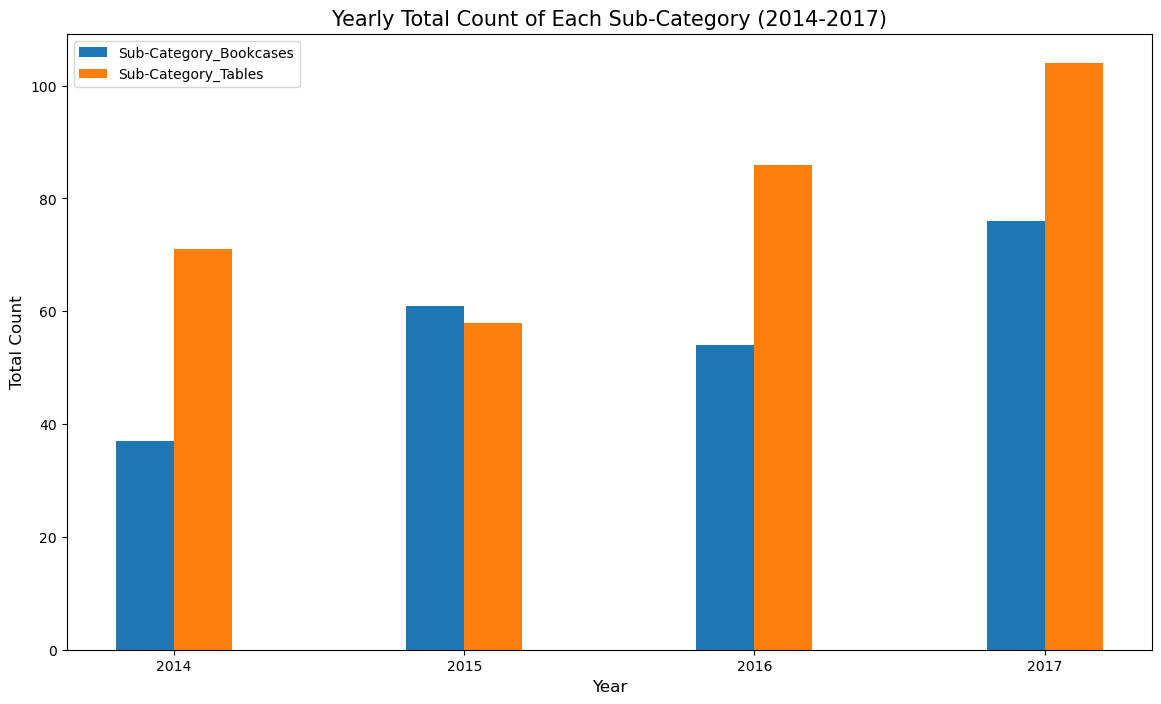

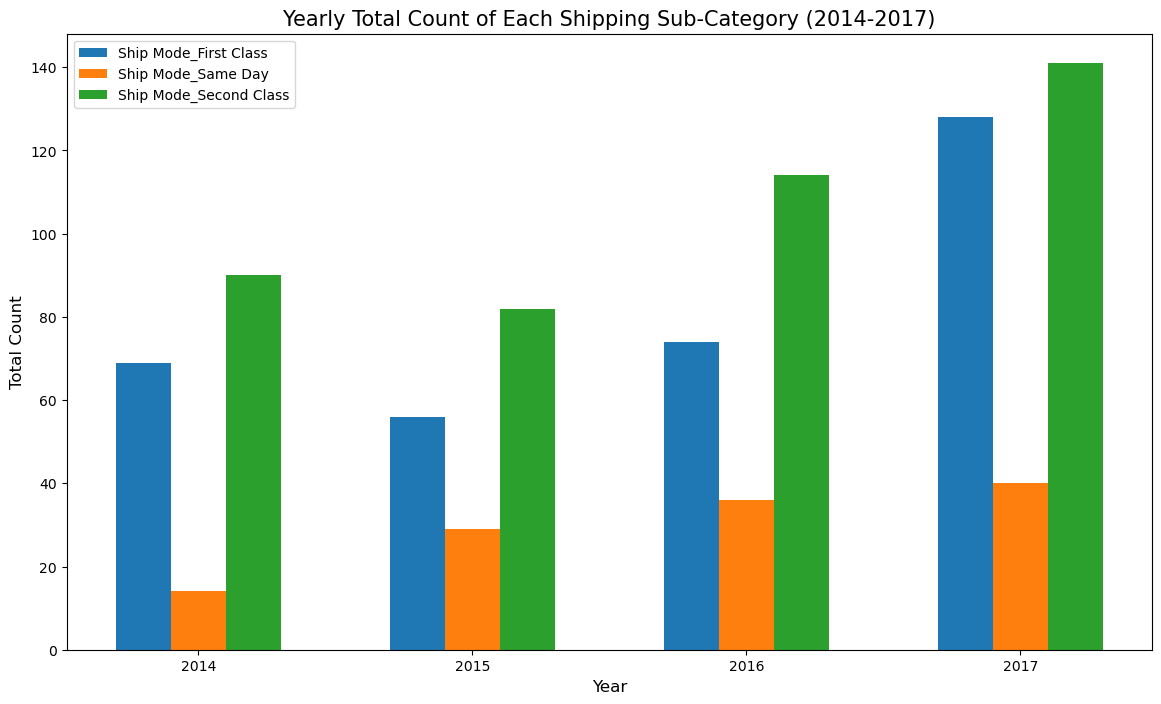

In [16]:
# Extract year from 'Order Date'
#monthly_resampled_df['Year'] = monthly_resampled_df['Order Date'].dt.year
monthly_red_cols['Year'] = monthly_red_cols.index.year

# List of sub-category columns
sub_category_columns = ['Sub-Category_Bookcases', 'Sub-Category_Tables']
sub_category_columns2 = ['Ship Mode_First Class','Ship Mode_Same Day', 'Ship Mode_Second Class']
#Group by year and sum the sales and sub-category counts
yearly_aggregated = monthly_red_cols.groupby('Year').agg({
    'Sales': 'sum',
    'Sub-Category_Bookcases': 'sum',
    'Sub-Category_Tables': 'sum',
    'Ship Mode_First Class': 'sum',
    'Ship Mode_Same Day': 'sum',
    'Ship Mode_Second Class':'sum'
}).reset_index()

# Plotting the bar graph
years = yearly_aggregated['Year']
bar_width = 0.2  # Width of each bar

# Generate positions for each group of bars
bar_positions = [years + bar_width * i for i in range(len(sub_category_columns))]

plt.figure(figsize=(14, 8))

# Plot each sub-category
for i, col in enumerate(sub_category_columns):
    plt.bar(bar_positions[i], yearly_aggregated[col], width=bar_width, label=col)

# Adjust x-axis labels to be in the middle of the grouped bars
mid_positions = [year + (len(sub_category_columns) - 1) * bar_width / 2 for year in years]
plt.xticks(mid_positions, years)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Yearly Total Count of Each Sub-Category (2014-2017)', fontsize=15)
plt.legend()
plt.show()

#Shipping method plots
bar_positions2 = [years + bar_width * i for i in range(len(sub_category_columns2))]

plt.figure(figsize=(14, 8))

# Plot each sub-category
for i, col in enumerate(sub_category_columns2):
    plt.bar(bar_positions2[i], yearly_aggregated[col], width=bar_width, label=col)

# Adjust x-axis labels to be in the middle of the grouped bars
mid_positions = [year + (len(sub_category_columns2) - 1) * bar_width / 2 for year in years]
plt.xticks(mid_positions, years)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Yearly Total Count of Each Shipping Sub-Category (2014-2017)', fontsize=15)
plt.legend()
plt.show()

## Save preprocessed data into file 


In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data (excluding the index)
scaled_data = scaler.fit_transform(monthly_red_cols)

# Create a DataFrame with the scaled data
scaled_monthly_red_cols = pd.DataFrame(scaled_data, index=monthly_red_cols.index, columns=monthly_red_cols.columns)

# Verify the standardized DataFrame
print(scaled_monthly_red_cols.head())

            Discount     Sales    Profit  Sub-Category_Bookcases  \
Order Date                                                         
2014-01-31  0.749564 -1.023015  0.393735                0.081022   
2014-02-28 -0.432650 -1.511763 -0.246593               -1.539416   
2014-03-31  0.782421 -0.098171 -1.414849               -0.567153   
2014-04-30 -1.755346 -0.834047  0.158946               -1.215329   
2014-05-31  2.663430 -0.948612 -0.686620               -0.891241   

            Sub-Category_Tables  Region_Central  Region_South  State_Alabama  \
Order Date                                                                     
2014-01-31            -1.320852       -1.114452      0.265417      -0.391115   
2014-02-28            -1.320852       -1.114452     -1.449583      -0.391115   
2014-03-31             0.316809       -0.559154      0.510417      -0.391115   
2014-04-30             0.082858       -1.114452     -0.469583       3.022252   
2014-05-31            -0.618997       -0.18

In [23]:
# Save the DataFrame to a CSV file
monthly_red_cols.to_csv('monthly_red_cols.csv', index=True)

NameError: name 'monthly_red_cols' is not defined

In [12]:
weekly_resampled_df = aggregated_df.resample('W').agg({
    'Discount': 'mean',
    
    # One-hot encoded columns should be summed
    **{col: 'sum' for col in aggregated_df.columns if col not in ['Discount']}
})

In [13]:
weekly_resampled_df.describe()

Discount         Sales    Quantity       Profit  \
count  208.000000    208.000000  208.000000   208.000000   
mean     0.178418   3567.306708   38.596154    88.708042   
std      0.081822   2805.029868   24.095831   472.042915   
min      0.000000     14.560000    1.000000 -1818.523200   
25%      0.133000   1681.124375   21.000000  -125.388525   
50%      0.167778   2831.073500   34.000000    54.164250   
75%      0.222813   4636.320250   53.000000   298.466525   
max      0.600000  16008.172000  152.000000  2173.561300   

       Sub-Category_Bookcases  Sub-Category_Chairs  Sub-Category_Furnishings  \
count              208.000000           208.000000                208.000000   
mean                 1.096154             2.966346                  4.600962   
std                  1.120897             2.380237                  3.133025   
min                  0.000000             0.000000                  0.000000   
25%                  0.000000             1.000000                  2.000000   
50%                  1.000000             2.500000                  4.000000   
75%                  2.000000             4.000000                  6.000000   
max                  5.000000            11.000000                 18.000000   

       Sub-Category_Tables  Region_Central  Region_East  ...  \
count           208.000000      208.000000   208.000000  ...   
mean              1.533654        2.312500     2.889423  ...   
std               1.396622        2.024831     2.494880  ...   
min               0.000000        0.000000     0.000000  ...   
25%               0.000000        1.000000     1.000000  ...   
50%               1.000000        2.000000     2.000000  ...   
75%               2.000000        3.250000     4.000000  ...   
max               7.000000       11.000000    14.000000  ...   

       State_West Virginia  State_Wisconsin  State_Wyoming  \
count           208.000000       208.000000     208.000000   
mean              0.004808         0.153846       0.004808   
std               0.069338         0.534224       0.069338   
min               0.000000         0.000000       0.000000   
25%               0.000000         0.000000       0.000000   
50%               0.000000         0.000000       0.000000   
75%               0.000000         0.000000       0.000000   
max               1.000000         3.000000       1.000000   

       Ship Mode_First Class  Ship Mode_Same Day  Ship Mode_Second Class  \
count             208.000000          208.000000              208.000000   
mean                1.572115            0.572115                2.052885   
std                 1.729145            0.970378                1.941684   
min                 0.000000            0.000000                0.000000   
25%                 0.000000            0.000000                1.000000   
50%                 1.000000            0.000000                2.000000   
75%                 2.000000            1.000000                3.000000   
max                 8.000000            5.000000                9.000000   

       Ship Mode_Standard Class  Segment_Consumer  Segment_Corporate  \
count                208.000000        208.000000         208.000000   
mean                   6.000000          5.350962           3.105769   
std                    4.025282          3.691863           2.368955   
min                    0.000000          0.000000           0.000000   
25%                    3.000000          2.000000           1.000000   
50%                    5.000000          5.000000           3.000000   
75%                    8.000000          7.000000           4.250000   
max                   20.000000         18.000000          11.000000   

       Segment_Home Office  
count           208.000000  
mean              1.740385  
std               1.872740  
min               0.000000  
25%               0.000000  
50%               1.000000  
75%               3.000000  
max              11.000000  

[8 rows x 67 co

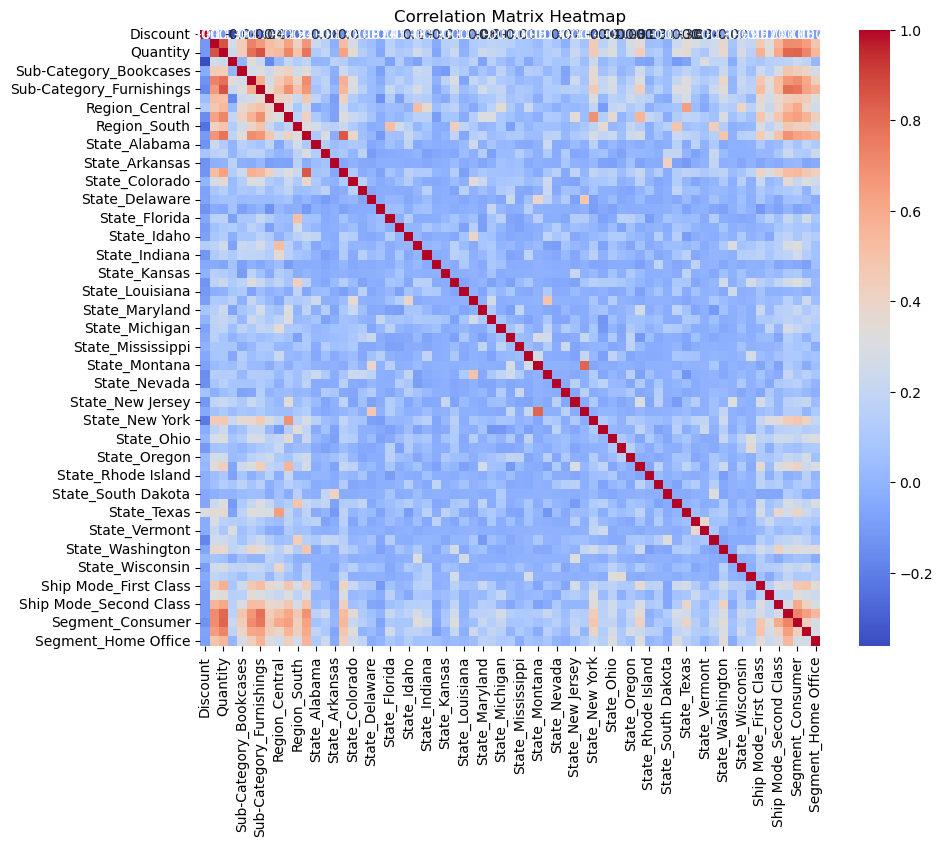

In [15]:
# correlation matrix
correlation_matrix = weekly_resampled_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [18]:
#Feature selection to help reduce the correlation between the variables
corr_matrix = weekly_resampled_df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than a threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features
weekly_reduced_df = weekly_resampled_df.drop(columns=to_drop)

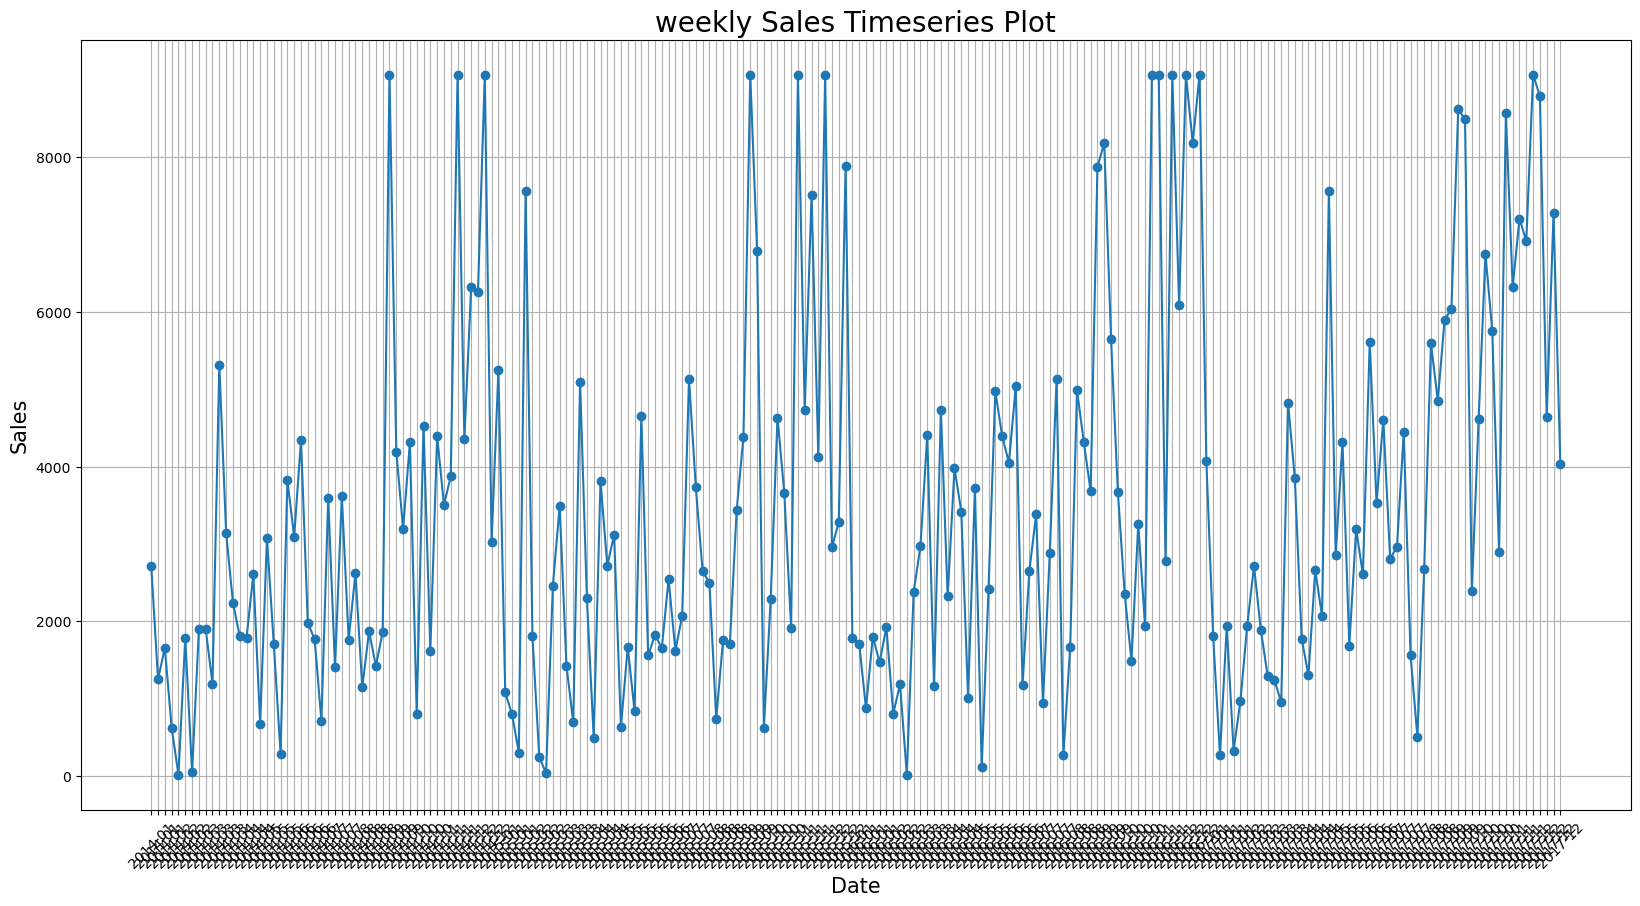

In [22]:
# Plotting the line graph of sales by date
#monthly_resampled_df = monthly_resampled_df.reset_index() #reset the index to gain access to the order date column
plt.figure(figsize=(20, 10))
plt.plot(weekly_reduced_df.index, weekly_reduced_df["Sales"], marker='o', linestyle='-')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title("weekly Sales Timeseries Plot", fontsize=20)
plt.xticks(weekly_reduced_df.index, [x.strftime('%Y-%m') for x in weekly_reduced_df.index], rotation=45)
plt.grid(True)
plt.show()

In [24]:
# Save the DataFrame to a CSV file
weekly_reduced_df.to_csv('weekly_reduced_df.csv', index=True)

In [27]:
weekly_reduced_df.head(10)

Discount     Sales  Quantity    Profit  Sub-Category_Bookcases  \
Order Date                                                                   
2014-01-12  0.150000  2712.428        15  717.0750                       0   
2014-01-19  0.368750  1250.473        24 -254.0044                       3   
2014-01-26  0.066667  1655.958        26  355.6263                       1   
2014-02-02  0.175000   623.666         5  -13.2304                       1   
2014-02-09  0.000000    14.560         2    5.5328                       0   
2014-02-16  0.100000  1779.618        12  119.5721                       0   
2014-02-23  0.300000    45.480         9   -4.4132                       0   
2014-03-02  0.340000  1893.995        23 -198.6240                       0   
2014-03-09  0.275000  1895.786        17 -141.6135                       1   
2014-03-16  0.133333  1193.936        12  292.4088                       0   

            Sub-Category_Chairs  Sub-Category_Furnishings  \
Order Date                                                  
2014-01-12                    1                         3   
2014-01-19                    1                         1   
2014-01-26                    1                         7   
2014-02-02                    0                         0   
2014-02-09                    0                         1   
2014-02-16                    2                         1   
2014-02-23                    0                         2   
2014-03-02                    3                         1   
2014-03-09                    3                         0   
2014-03-16                    1                         2   

            Sub-Category_Tables  Region_Central  Region_East  ...  \
Order Date                                                    ...   
2014-01-12                    0               1            1  ...   
2014-01-19                    0               0            2  ...   
2014-01-26                    0               3            0  ...   
2014-02-02                    1               0            0  ...   
2014-02-09                    0               0            0  ...   
2014-02-16                    1               2            0  ...   
2014-02-23                    0               2            0  ...   
2014-03-02                    1               4            0  ...   
2014-03-09                    1               0            1  ...   
2014-03-16                    0               0            1  ...   

            State_West Virginia  State_Wisconsin  State_Wyoming  \
Order Date                                                        
2014-01-12                    0                0              0   
2014-01-19                    0                0              0   
2014-01-26                    0                0              0   
2014-02-02                    0                0              0   
2014-02-09                    0                0              0   
2014-02-16                    0                0              0   
2014-02-23                    0                0              0   
2014-03-02                    0                0              0   
2014-03-09                    0                0              0   
2014-03-16                    0                0              0   

            Ship Mode_First Class  Ship Mode_Same Day  Ship Mode_Second Class  \
Order Date                                                                      
2014-01-12                      1                   0                       0   
2014-01-19                      2                   0                       2   
2014-01-26                      1                   0                       1   
2014-02-02                      1                   0                       0   
2014-02-09                      1                   0                       0   
2014-02-16                      0                   0                       2   
2014-02-23                      0                   1       


## 5. Summary